## Notebook to plot predictions of graph vs MLP

Plot examples predictions and distance on patients

Done on test data



In [1]:
import os
import sys
import numpy as np
sys.path.append('/home/co-ripa1/rds/hpc-work/scripts/meld_classifier')
import h5py
import matplotlib_surface_plotting as msp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import nibabel as nb
import meld_graph.experiment
from meld_classifier.paths import BASE_PATH
from meld_classifier.meld_cohort import MeldCohort,MeldSubject


Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350
Setting MELD_DATA_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/
Setting FS_SUBJECTS_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data


In [2]:
def load_prediction(subject,hdf5,dset='prediction'):
    results={}
    with h5py.File(hdf5, "r") as f:
        for hemi in ['lh','rh']:
            results[hemi] = f[subject][hemi][dset][:]
    return results


In [3]:
model_graph = '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_LVHZ_dcp/s_0/fold_all'
model_pervertex= '/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/iteration_21-09-15/ensemble_21-09-15/fold_all/results'

In [4]:
exp = meld_graph.experiment.Experiment.from_folder(model_graph)

features = exp.data_parameters["features"]
cohort = MeldCohort(
        hdf5_file_root=exp.data_parameters["hdf5_file_root"],
        dataset=exp.data_parameters["dataset"],
    )

Initialised Experiment 23-10-30_LVHZ_dcp/s_0


/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_LVHZ_dcp/s_0/fold_all


In [5]:
with h5py.File(os.path.join(model_graph, 'results_best_model', 'predictions.hdf5'), "r") as f:
    subjects_test = list(f.keys())
len(subjects_test)

453

In [6]:
import matplotlib_surface_plotting as msp
from meld_classifier.meld_plotting import trim
from PIL import Image

def load_predictions_for_subject(subj,model_dir,cohort,):
    #load mask
    s = MeldSubject(subj,cohort=cohort)
    hemi=s.get_lesion_hemisphere()
    dists, label = s.load_feature_lesion_data(
                    features=['.on_lh.boundary_zone.mgh'], hemi=hemi, features_to_ignore=[]
                    )
    seg_pred = np.zeros(len(cohort.cortex_mask))
    dist_pred = np.zeros(len(cohort.cortex_mask))
    pred_file = os.path.join(model_dir, 'predictions.hdf5')
    result_hemis = load_prediction(subj,pred_file, dset='prediction_clustered')
    seg_pred[cohort.cortex_mask] = result_hemis[hemi]
    distance_map = load_prediction(subj,pred_file, dset='distance_map')
    dist_pred[cohort.cortex_mask] = distance_map[hemi]
    file = os.path.join(model_pervertex, 'predictions_ensemble_iteration.hdf5')
    per_vertex = np.zeros(len(cohort.cortex_mask))
    per_vertex[cohort.cortex_mask] = load_prediction(subj,file, dset='prediction')[hemi]
    return label,seg_pred,dist_pred,per_vertex
    

In [69]:
# initialise subjects
subjects=[    
        # 'MELD_H21_15T_FCD_0050',
        # 'MELD_H4_3T_FCD_0016',
        # 'MELD_H16_3T_FCD_016',
        
       'MELD_H10_3T_FCD_0002',


        ]

In [58]:
subjects = subjects_test
for subj in subjects:
    # print(subj)
    # get predictions and distance maps
    if '_FCD_' in subj: 
        label,seg_pred,dist_pred,per_vertex = load_predictions_for_subject(subj, os.path.join(model_graph, 'results_best_model'),cohort)

        if ((seg_pred==label).any()):
            if((per_vertex==label).any()):
                pass
            else:
                print(subj)
    

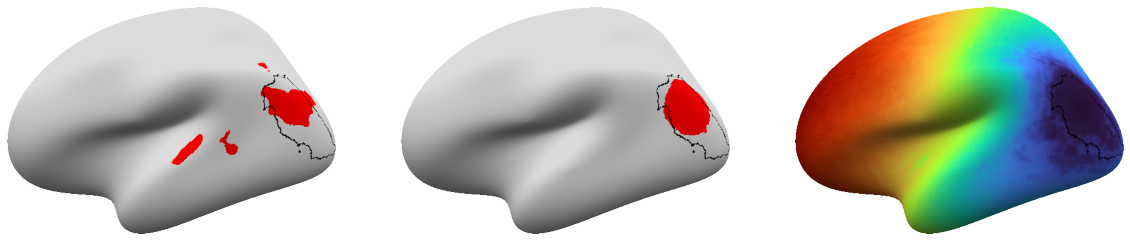

In [70]:
## plot prediction against MLP

for subj in subjects:
    # get predictions and distance maps
    label,seg_pred,dist_pred,per_vertex = load_predictions_for_subject(subj, os.path.join(model_graph, 'results_best_model'),cohort)

    #plot predictions using per-vertex graph
    per_vertex = per_vertex>0
    msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'],per_vertex,rotate=[90],
        cmap='bwr',
        base_size = 20,filename='tmp1.png', colorbar=False,mask=~per_vertex,
        parcel=label,parcel_cmap={0:[0,0,0,1],1:[0,0,0,1]})
    plt.close()
    im = Image.open('tmp1.png')
    trimmed_pv = trim(im)

    #plot predictions new graph and distance
    msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'],seg_pred,
                  rotate=[90],cmap='bwr',
                    base_size = 20,filename='tmp1.png', colorbar=False,mask=~seg_pred.astype(bool),
                    parcel=label,parcel_cmap={0:[0,0,0,1],1:[0,0,0,1]})
    plt.close()
    im = Image.open('tmp1.png')
    trimmed_graph = trim(im)
    msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'],dist_pred,
                  rotate=[90],cmap='turbo',
                    base_size = 20,filename='tmp1.png', colorbar=False,#mask=~per_vertex,
                    parcel=label,parcel_cmap={0:[0,0,0,1],1:[0,0,0,1]})
    plt.close()
    im = Image.open('tmp1.png')
    trimmed_dist = trim(im)

    #combine plots
    fig,ax = plt.subplots(1,3,figsize=(20,10))
    ax[0].imshow(trimmed_pv)
    ax[1].imshow(trimmed_graph)
    ax[2].imshow(trimmed_dist)
    for ax in ax:
        ax.axis('off')

    #save plot
    plt.savefig(f'{model_graph}/results_best_model/images/examples_patients_graphvsMLP_{subj}.png', transparent=True)

